# Imports

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sympy import *
from sympy.parsing.sympy_parser import parse_expr

from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

# Some constents

In [2]:
BOUNDARY_POINT = 5
BOUNDARY_POINT_MARGINE = 20
POINTS_RANGE = (-2000, 2000)
TOTAL_POINTS = 1000

TEST_RATIO = 0.3
EPOCHS = 2
LEARNING_RATE = 0.00001

CLASS_A_CLR = 'red'
CLASS_B_CLR = 'blue'

# Perceptron class

In [18]:
class Perceptron:
    LEARNING_RATE = 0.01
    
    def __init__(self, input_size, learning_rate=0.01):
        self._input_size = input_size
        self.LEARNING_RATE = learning_rate

        self._weights = np.random.rand(input_size)
        self._bias = np.random.rand()

        self._previous_weights = np.array([self._weights])
        self._previous_biases = np.array([self._bias])

    def predict(self, point):
        sum_of_product = (self._weights * point).sum() + self._bias
        return self._activation_function(sum_of_product)

    def predict_from_array(self, points):
        return np.array([self.predict(point) for point in points])
    
    def fit(self, x, y, epochs=1, mse_history=False):
        mse_arr = np.array([])

        for epoch in range(epochs):
            predicted = self.predict_from_array(x)
            self.update_weight_and_bias(x, y, predicted)

            mse = self.mean_square_error(predicted, y)
            mse_arr = np.append(mse_arr, mse)            

        if mse_history:
            return mse, mse_arr
        return mse

    def update_weight_and_bias(self, points, real, predicted):
        dw, db = self._calc_slope(points, predicted, real)

        self._weights -= dw
        self._bias -= db

        self._previous_weights = np.append(self._previous_weights, [dw], axis=0)
        self._previous_biases = np.append(self._previous_biases, db)

    # Calculate the slope/gradient of error function
    def _calc_slope(self, points, predicted, real):
        sample_size = points.shape[0]
        predicted_real_diff = predicted - real
        activation_function_derivative = self._activation_function_derivative()

        dw = (2/sample_size) * (self.LEARNING_RATE * (predicted_real_diff * activation_function_derivative)[:, None] * points).sum(0)
        db = (2/sample_size) * (self.LEARNING_RATE * (predicted_real_diff * activation_function_derivative)).sum(0)
#         print((2/sample_size) * (self.LEARNING_RATE * (predicted_real_diff * activation_function_derivative)[:, None] * points).sum(0))
        return dw, db

    def get_loss_func_equation(self, points, predicted):
        n = points.shape[0]

        loss_func_str = '+'.join([f'({points[i, 0]}*w+b-{predicted[i]})**2' for i in range(n)])
        loss_func_str = f'1/{n}*({loss_func_str})'

        loss_func_simplified = simplify(parse_expr(loss_func_str))

        w, b = symbols('w b')
        loss_func_lambda = lambdify([w, b], loss_func_simplified)
        
        return loss_func_simplified, loss_func_lambda
    
    def set_optimum_w_and_b(self, points):
#         training_prediction = self.predict_from_array(points)
#         loss_func_sympy, loss_func_lambda = model.get_loss_func_equation(points, training_prediction)
#         help(loss_func_lambda)
        loss_func_sympy = parse_expr('1.0*b**2 + 78.765714285714284*b*w - 42768.590992469627*b + 1362694.0314285714*w**2 - 1479783141.3830811*w + 401733275229.482')
        w, b = symbols('w b')

        # First we'll find stationary points
        dw = diff(loss_func_sympy, w)
        db = diff(loss_func_sympy, b)
        stationary_points = solve([dw, db], (w, b))

        self._weights = np.array([stationary_points[w]])
        self._bias = stationary_points[b]


    def mean_square_error(self, predicted, real):
        return ((predicted - real) ** 2).mean()
    
    # Calculate and return the slope and y-intercept for decision boundry
    def get_decision_boundry_m_and_b(self):
        # This method only works for 2 input perceptron
        # Todo: Have to generalize it
        m = -self._weights[0] / self._weights[1]
        b = -self._bias / self._weights[1]

        return m, b

    def _activation_function(self, input):
        # After changing the activation function
        # Also update the derivative of activation function
        # In _activation_function_derivative()
        return input
    def _activation_function_derivative(self):
        return 1
    
    # Some properties
    @property
    def weights(self):
        return self._weights
    @property
    def bias(self):
        return self._bias
    @property
    def previous_weights(self):
        return self._previous_weights
    @property
    def previous_biases(self):
        return self._previous_biases

# model = Perceptron(1, LEARNING_RATE)
# model.fit(X_train, y_train, epochs=EPOCHS)

# Generating training & testing points

In [4]:
class_a_x = np.random.randint(POINTS_RANGE[0], BOUNDARY_POINT-BOUNDARY_POINT_MARGINE, size=(TOTAL_POINTS//2, 1))
class_b_x = np.random.randint(BOUNDARY_POINT+BOUNDARY_POINT_MARGINE, POINTS_RANGE[1], size=(TOTAL_POINTS//2, 1))
class_a_y = np.zeros(TOTAL_POINTS//2)
class_b_y = np.zeros(TOTAL_POINTS//2)

X = np.concatenate((class_a_x, class_b_x))
y = np.concatenate((np.zeros(TOTAL_POINTS//2), np.ones(TOTAL_POINTS//2)))

## Plotting points

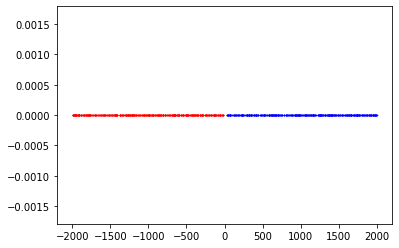

In [5]:
plt.scatter(class_a_x, class_a_y, c=CLASS_A_CLR, s=0.5)
plt.scatter(class_b_x, class_b_y, c=CLASS_B_CLR, s=0.5)

## Splitting training & test points

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO)

TOTAL_TRAIN_POINTS = X_train.shape[0]

# Creating model

In [7]:
model = Perceptron(1, LEARNING_RATE)

## Training

In [8]:
_, mse_arr = model.fit(X_train, y_train, epochs=EPOCHS, mse_history=True)

### Plotting MSE

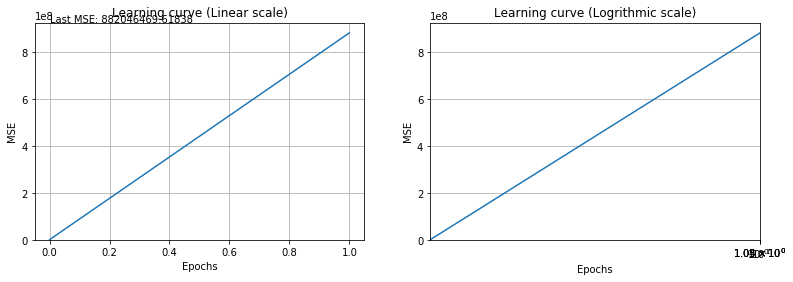

In [9]:
fig, (plt1, plt2) = plt.subplots(1, 2)
fig.set_figwidth(13)

plt1.plot(np.arange(EPOCHS), mse_arr)
plt1.set_title('Learning curve (Linear scale)')
plt1.set_xlabel('Epochs')
plt1.set_ylabel('MSE')
plt1.grid(True)
x_min, x_max, y_min, y_max = plt1.axis()
plt1.axis((x_min, x_max, 0, y_max))
plt1.text(0, y_max-150, f'Last MSE: {mse_arr[-1]}')

plt2.plot(np.arange(EPOCHS), mse_arr)
plt2.set_title('Learning curve (Logrithmic scale)')
plt2.set_xlabel('Epochs')
plt2.set_ylabel('MSE')
plt2.grid(True)
x_min, x_max, y_min, y_max = plt2.axis()
plt2.axis((x_min, x_max, 0, y_max))
plt2.set_xscale('log')

## Testing

In [10]:
predict = model.predict_from_array(X_test)

X_test_class_a = X_test[predict < 0]
X_test_class_b = X_test[predict >= 0]

### Plotting prediction & real data

Text(0.5, 1.0, 'True Classification')

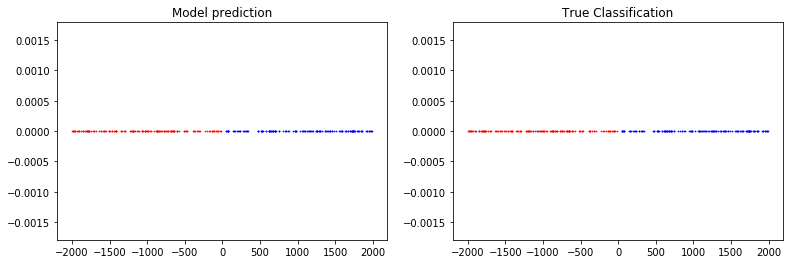

In [11]:
true_X_test_class_a = X_test[y_test == 0]
true_X_test_class_b = X_test[y_test == 1]

fig, (plot1, plot2) = plt.subplots(1, 2)
fig.set_figwidth(13)

plot1.scatter(X_test_class_a, np.zeros(X_test_class_a.shape[0]), c=CLASS_A_CLR, s=0.5)
plot1.scatter(X_test_class_b, np.zeros(X_test_class_b.shape[0]), c=CLASS_B_CLR, s=0.5)
plot1.set_title('Model prediction')

plot2.scatter(true_X_test_class_a, np.zeros(true_X_test_class_a.shape[0]), c=CLASS_A_CLR, s=0.5)
plot2.scatter(true_X_test_class_b, np.zeros(true_X_test_class_b.shape[0]), c=CLASS_B_CLR, s=0.5)
plot2.set_title('True Classification')

# Calculating loss function

In [12]:
# training_prediction = model.predict_from_array(X_train)
# loss_func_sympy, loss_func_lambda = model.get_loss_func_equation(X_train, training_prediction)

In [13]:
# grid_x, grid_y = np.meshgrid(np.arange(-10, 10), np.arange(-10, 10))
# plot_points = loss_func_lambda(grid_x, grid_y)

In [14]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(grid_x, grid_y, plot_points)

In [17]:
model.set_optimum_w_and_b(X_train)